In [1]:
import mnist_util as mu
import numpy as np
from random import randint
from scipy.stats import multivariate_normal
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Importing Training and Test Data

In [2]:
# importing training images and test images
trainX, trainY, testX, testY = mu.get_np_array()
classes = np.arange(10)

### Plotting some numbers

showing picture number: 12733


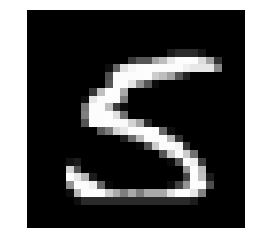

In [3]:
# show a random number in the trainings set
rnd = randint(0, len(trainX)-1)
print("showing picture number: {rnd}".format(rnd=rnd))
mu.show_a_num(trainX[rnd])

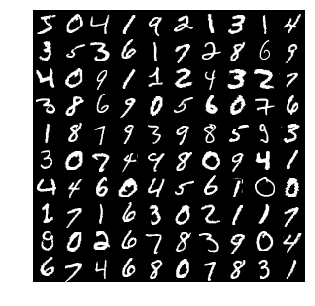

In [4]:
# show the first 100 images in the trainings data set
testing = trainX[:100]
mu.show_nums(testing, xsize=5, ysize=5)

## Sorting the numbers by class

In [5]:
# create arrays for only the specific numbers
num_arrays = mu.get_all_nums(trainX, trainY)

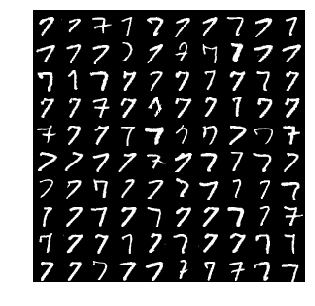

In [6]:
# show the first 100 images of number 7
num = num_arrays[7]
mu.show_nums(num[:100], xsize=5, ysize=5)

## Calculating mean and log priors for each class

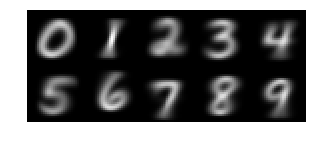

In [7]:
# calculate means for all numbers
mean = [np.mean(num_arrays[i], axis=0) for i in range(10)]

# calculate log priors for all numbers
logpriors = np.array([np.log(i.shape[0]/trainX.shape[0]) for i in num_arrays])

# print mean for each number
mu.show_nums(np.array(mean), nrow=2, xsize=5, ysize=5)

In [8]:
# predict test data with distributions for each number
def predict_nums(dists, test):
    res = []
    for t in test:
        # find number with highest logpdf
        argmax = np.argmax([logpriors[i] + pdf.logpdf(t) for i, pdf in enumerate(dists)])
        res.append(argmax)
    return res

In [9]:
# find the incorrectly labeled numbers
def find_wrong(data, labels, pred):
    # sort data and merge it into one array
    data = mu.get_all_nums(data, labels)
    data = np.vstack(data)
    
    # sort labels and predictions
    stack = np.array(list(zip(labels,pred)))
    stack = stack[stack[:,0].argsort(kind='mergesort')]
    # return the incorrectly labeled numbers
    return data[np.where(stack[:,0] != stack[:,1])]

## Classifying MNIST Test Data with identity matrix as covariance

In [10]:
# calculate pdf's for all numbers
p_id  = [multivariate_normal(mean=mean[i], cov=1) for i in range(10)]

# predict test data
result_id = predict_nums(p_id, testX)

Loss Id:  0.17969999999999997


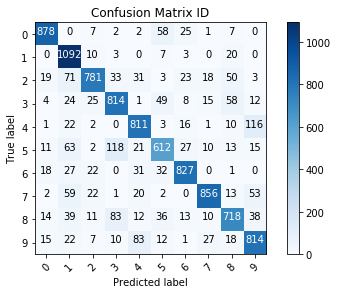

In [11]:
# calculate zero-one-loss
loss_id  = zero_one_loss(testY, result_id)
print("Loss Id:  {}".format(loss_id))

# calculate confusion matrix
cm_id  = confusion_matrix(testY, result_id)

# print confusion matrix
mu.plot_confusion_matrix(cm_id, title='Confusion Matrix ID', classes=classes)

(1797, 784)


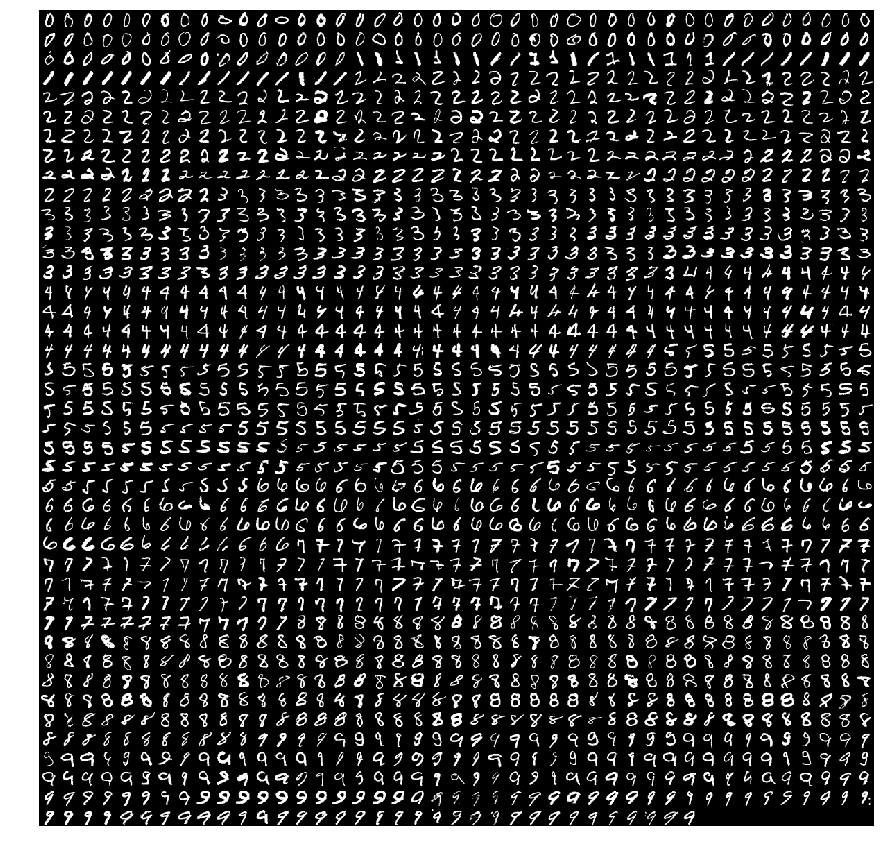

In [12]:
# show wrong classified numbers
wrong_id = find_wrong(testX, testY, result_id)
mu.show_nums(wrong_id)
print(wrong_id.shape)

## Classifying MNIST Test Data with variance * identity matrix as covariance

In [13]:
# calculate variance
sigma_var = [np.var(num_arrays[i]) for i in range(10)]

# calculate pdf's for all numbers
p_var = [multivariate_normal(mean=mean[i], cov=sigma_var[i]) for i in range(10)]

# predict test data
result_var = predict_nums(p_var, testX)

Loss Var: 0.22450000000000003


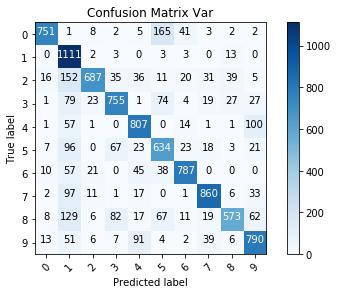

In [14]:
# calculate zero-one-loss
loss_var = zero_one_loss(testY, result_var)
print("Loss Var: {}".format(loss_var))

# calculate confusion matrix
cm_var = confusion_matrix(testY, result_var)

# print confusion matrix for sigma = var * I
mu.plot_confusion_matrix(cm_var, title='Confusion Matrix Var', classes=classes)

(2245, 784)


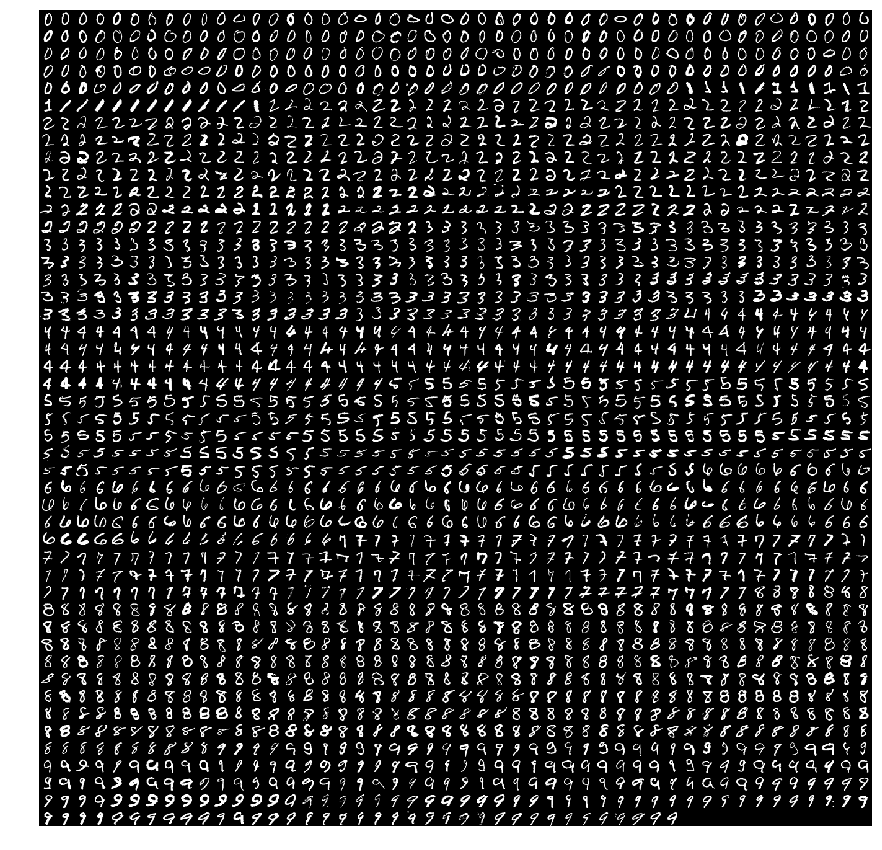

In [15]:
# show wrong classified numbers
wrong_var = find_wrong(testX, testY, result_var)
mu.show_nums(wrong_var)
print(wrong_var.shape)

## Classifying MNIST Test Data with variance pixelwise

In [16]:
# calculate variance for each pixel
sigma_var2 = [np.var(num_arrays[i], axis=0) for i in range(10)]
identity = np.eye(testX.shape[1])

# calculate pdf's for all numbers
p_var2 = [multivariate_normal(mean=mean[i], cov=sigma_var2[i] @ identity, allow_singular=True) for i in range(10)]

# predict test data
result_var2 = predict_nums(p_var2, testX)

Loss Var2: 0.3517


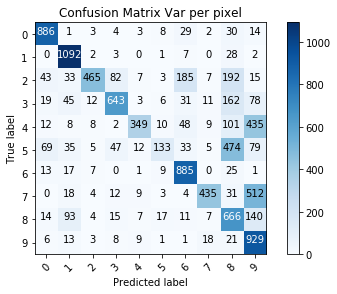

In [17]:
# calculate zero-one-loss
loss_var2 = zero_one_loss(testY, result_var2)
print("Loss Var2: {}".format(loss_var2))

# calculate confusion matrix
cm_var2 = confusion_matrix(testY, result_var2)

# print confusion matrix for sigma = covariance matrix
mu.plot_confusion_matrix(cm_var2, title='Confusion Matrix Var per pixel', classes=classes)

(3517, 784)


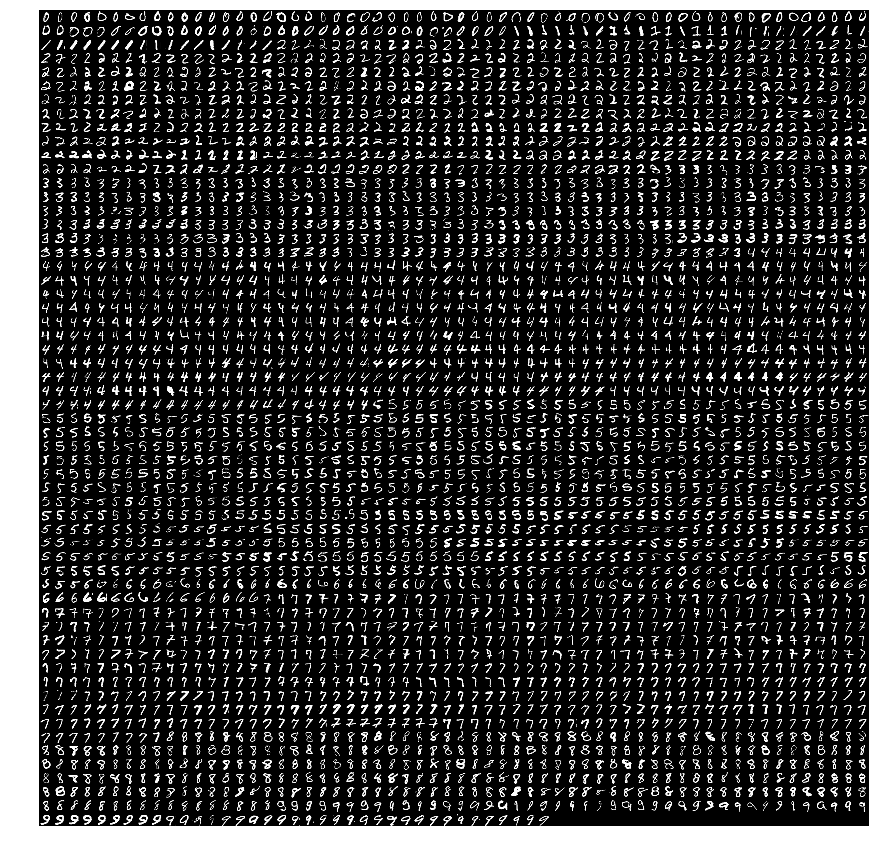

In [18]:
# show wrong classified numbers
wrong_var2 = find_wrong(testX, testY, result_var2)
mu.show_nums(wrong_var2)
print(wrong_var2.shape)

## Classifying MNIST Test Data with covariance

In [19]:
# calculate covariance
sigma_cov = [np.cov(num_arrays[i].T) for i in range(10)]

# calculate pdf's for all numbers
p_cov = [multivariate_normal(mean=mean[i], cov=sigma_cov[i], allow_singular=True) for i in range(10)]

# predict test data
result_cov = predict_nums(p_cov, testX)

Loss Cov: 0.18620000000000003


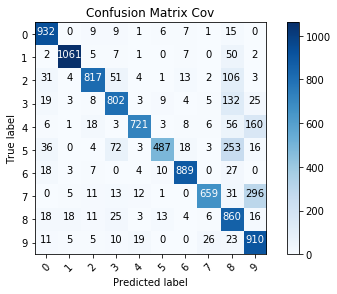

In [20]:
# calculate zero-one-loss
loss_cov = zero_one_loss(testY, result_cov)
print("Loss Cov: {}".format(loss_cov))

# calculate confusion matrix
cm_cov = confusion_matrix(testY, result_cov)

# print confusion matrix for sigma = covariance matrix
mu.plot_confusion_matrix(cm_cov, title='Confusion Matrix Cov', classes=classes)

(1862, 784)


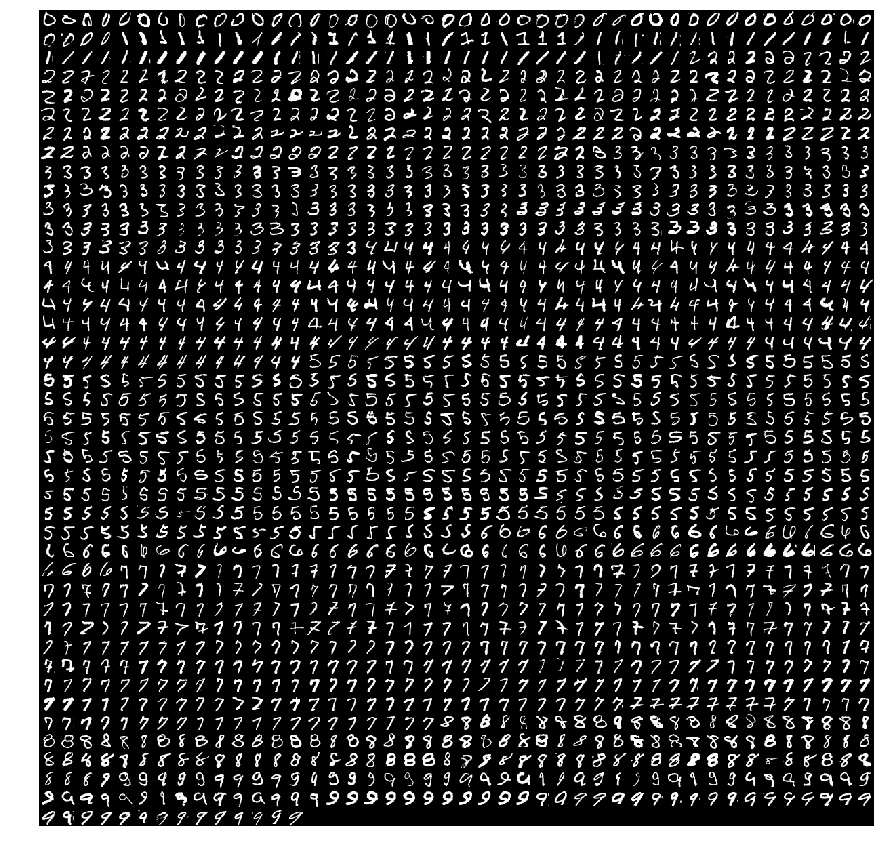

In [21]:
# show wrong classified numbers
wrong_cov = find_wrong(testX, testY, result_cov)
mu.show_nums(wrong_cov)
print(wrong_cov.shape)

## Classifying MNIST Test Data with smoothed covariance
Formula for the smoothed covariance $ \Sigma $ of number $ j $: $ \Sigma_j = \Sigma_j + C*I $

$ I $ is the identity matrix and $ C $ is a hyperparameter that needs to be optamized against the test data!

In [22]:
# calculate smoothed covariance
C = 3500
cov_smoothed = [sigma_cov[i] + (C * np.eye(trainX.shape[1])) for i in range(10)]

# calculate pdf's for all numbers
p_cov_smoothed = [multivariate_normal(mean=mean[i], cov=cov_smoothed[i], allow_singular=True) for i in range(10)]

# predict test data
result_cov_smoothed = predict_nums(p_cov_smoothed, testX)

Loss Cov: 0.04379999999999995


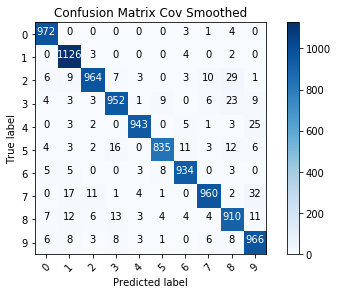

In [23]:
# calculate zero-one-loss
loss_cov_smoothed = zero_one_loss(testY, result_cov_smoothed)
print("Loss Cov: {}".format(loss_cov_smoothed))

# calculate confusion matrix
cm_cov_smoothed = confusion_matrix(testY, result_cov_smoothed)

# print confusion matrix for sigma = smoothed covariance matrix
mu.plot_confusion_matrix(cm_cov_smoothed, title='Confusion Matrix Cov Smoothed', classes=classes)

(438, 784)


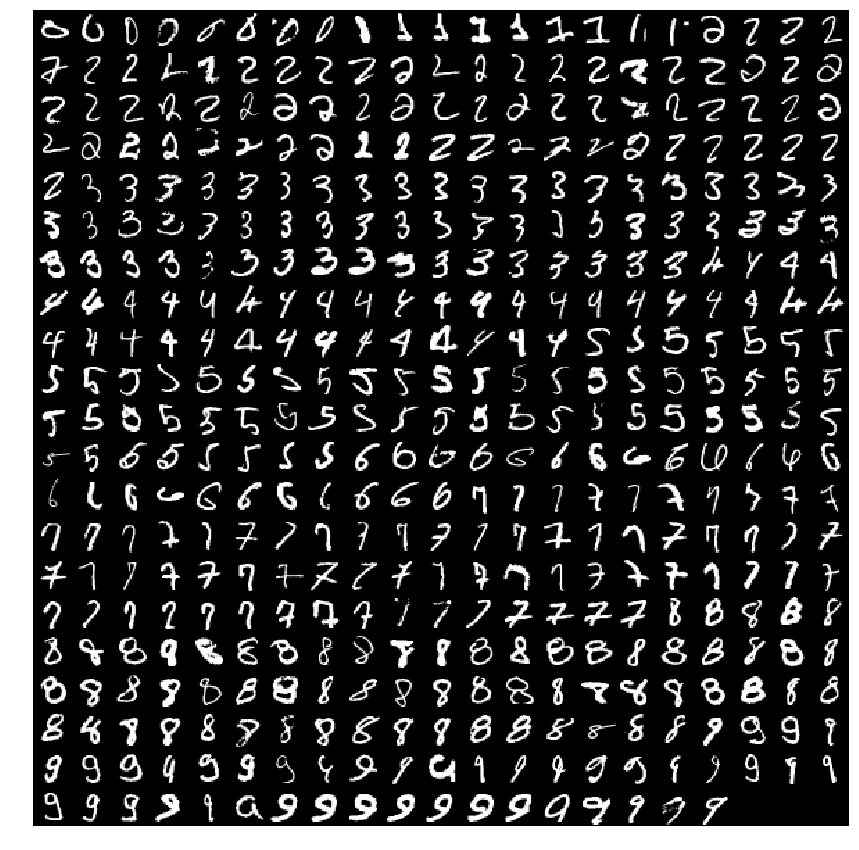

In [24]:
# show wrong classified numbers
wrong_cov_smoothed = find_wrong(testX, testY, result_cov_smoothed)
mu.show_nums(wrong_cov_smoothed)
print(wrong_cov_smoothed.shape)

## Compare losses

In [30]:
print("Loss Id:          {0:.4f}".format(loss_id))
print("Loss Var:         {0:.4f}".format(loss_var))
print("Loss Var2:        {0:.4f}".format(loss_var2))
print("Loss Cov:         {0:.4f}".format(loss_cov))
print("Loss Cov Smooth:  {0:.4f}".format(loss_cov_smoothed))

Loss Id:          0.1797
Loss Var:         0.2245
Loss Var2:        0.3517
Loss Cov:         0.1862
Loss Cov Smooth:  0.0438
